<a href="https://colab.research.google.com/github/gcfcmu/Projects/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the required packages
install.packages("phylolm")
library(phylolm);
library(ggplot2)

# Download all necessary files

# Get the OPC predictions
peakUrl <- "https://www.andrew.cmu.edu/user/apfennin/2021_Fall_GEB/project/Corces2020.OPC.calibPeaks.avgCNN.predictions.txt.gz";
system(paste("wget ",peakUrl));

# Get the Microglia predictions
peakUrl <- "https://www.andrew.cmu.edu/user/apfennin/2021_Fall_GEB/project/Corces2020.Microglia.calibPeaks.avgCNN.predictions.txt.gz";
system(paste("wget ",peakUrl));

# Get the Species traits annotation
peakUrl <- "https://www.andrew.cmu.edu/user/apfennin/2021_Fall_GEB/project/Phenotypes_Zoonomia_3.csv"
system(paste("wget ",peakUrl));

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘ape’


Loading required package: ape



In [ ]:
# Read in species traits
Traits_annotation <- as.data.frame(read.csv(file=gzfile("/content/Phenotypes_Zoonomia_3.csv"),stringsAsFactors=F,header=T));
dim(Traits_annotation)

[1] 222 266

In [ ]:
# Reading in the Microglia predicted open chromatin peaks
microglia_pred <- as.data.frame(read.delim2(file=gzfile("/content/Corces2020.Microglia.calibPeaks.avgCNN.predictions.txt.gz"),stringsAsFactors=F,header=T));
opc_pred <- as.data.frame(read.delim2(file=gzfile("/content/Corces2020.OPC.calibPeaks.avgCNN.predictions.txt.gz"), stringsAsFactors = F, header = T))

In [ ]:
# Create a dataframe with the Trait of interest and remove all NA rows
trait_of_interest <- Traits_annotation[, c('X.1', 'Brain.resid')]
#trait_of_interest <- na.omit(trait_of_interest)
dim(trait_of_interest)
head(trait_of_interest)

dim(trait_of_interest)


[1] 222   2

,X.1,Brain.resid
,<chr>,<dbl>
1,Mus_musculus,-0.02220463
2,Acinonyx_jubatus,-0.16983411
3,Acomys_cahirinus,-0.01345730
4,Ailuropoda_melanoleuca,-0.13481005
5,Ailurus_fulgens,0.11963737
6,Allactaga_bullata,NA


[1] 222   2

In [ ]:
#species_of_interest = c('Eschrichtius_robustus', 'Lepus_americanus', 'Panthera_pardus', 'Mus_musculus', 'Canis_lupus_familiaris', 'Felis_catus', 'Pan_troglodytes', 'Tursiops_truncatus', 'Homo_sapiens', 'Peromyscus_maniculatus')

# Select the species of interest from the traits table 
traits = na.omit(trait_of_interest)

#traits = trait_of_interest[rownames(trait_of_interest) %in% species_of_interest, ]
rownames(traits) <- traits[, 1]

# Only select the columns which correspond to the species of interest
#rownames(microglia_pred) = microglia_pred$name
microglia_ocp = microglia_pred[, (colnames(microglia_pred) %in% rownames(traits))];


In [ ]:
# Create a tree to Phylogenetic Linear Regression analysis

# Download the Zoonomia Tree
treeUrl <- "http://www.andrew.cmu.edu/user/apfennin/2021_Fall_GEB/hw2/Zoonomia_ChrX_lessGC40_241species_30Consensus.tree";
system(paste("wget ",treeUrl));

zoonomiaTree <- read.tree(file = "Zoonomia_ChrX_lessGC40_241species_30Consensus.tree") #read tree in Newick format
zoonomiaTree

# Keep only the species with brain size residual data 

keep <- rownames(traits)
removeSpecV <- setdiff(zoonomiaTree$tip.label, keep)
keepTree <- drop.tip(zoonomiaTree, removeSpecV)



Phylogenetic tree with 241 tips and 240 internal nodes.

Tip labels:
  Trichechus_manatus, Loxodonta_africana, Heterohyrax_brucei, Procavia_capensis, Chrysochloris_asiatica, Microgale_talazaci, ...

Rooted; includes branch lengths.

In [ ]:


new <- traits 
new$c <- as.numeric(t(microglia_ocp[1,]))


# Rearrange the columns of microglia_ocp so that they have the same order as the traits data frame
# This ensures that the peaks, when running Phylolm, will give the correct predicted 
# chromatin for each species. This gives a different result in the analysis, 
# suggesting why the gene ontology analysis is more related to brain size residual

library(dplyr)

length(rownames(microglia_ocp))

microglia_ocp <- relocate(microglia_ocp, rownames(traits))

# test that each name is in fact equal
sum(colnames(microglia_ocp) != rownames(traits))

length(rownames(microglia_ocp))







Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 26408

[1] 0

[1] 26408

In [ ]:
# Performing the Phylogenetic Regression

Peaks <- rownames(microglia_ocp)

# Create vectors to store the results from the phylogenetic analysis
pval <- rep(NA,length(Peaks))
corr <- rep(NA,length(Peaks))
adj_corr <- rep(NA,length(Peaks))

Results_phylolm_micro = data.frame(id = Peaks, pval = pval, corr = corr, adj_corr = adj_corr)
rownames(Results_phylolm_micro) <- Results_phylolm_micro$Peaks

for(curPeak in Peaks){
  
  TempSpeciesInfo <- traits
  TempSpeciesInfo$curPeak <- as.numeric(t(microglia_ocp[curPeak,]))
 
  lmFit = suppressWarnings(phylolm(curPeak~Brain.resid, data = TempSpeciesInfo, phy = keepTree , model="BM"))
  lmFitSummary = summary(lmFit)


  Results_phylolm_micro[curPeak, "pval"] <- lmFitSummary$coefficients['Brain.resid',4]
  Results_phylolm_micro[curPeak, "corr"] <- lmFit$r.squared
  Results_phylolm_micro[curPeak, "adj_corr"] <- lmFit$adj.r.squared
}


Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”
Warning message in pt(-abs(tval), df = object$n - object$d):
“NaNs produced”

ERROR: ignored

In [ ]:
#For the phylogenetic analysis, around 250 of the peaks did not have enough data to assign meaningful results via Phylolm. 
#However, there are still over 26000 p-values that will be used in further analysis. 

[1] 26122     5

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


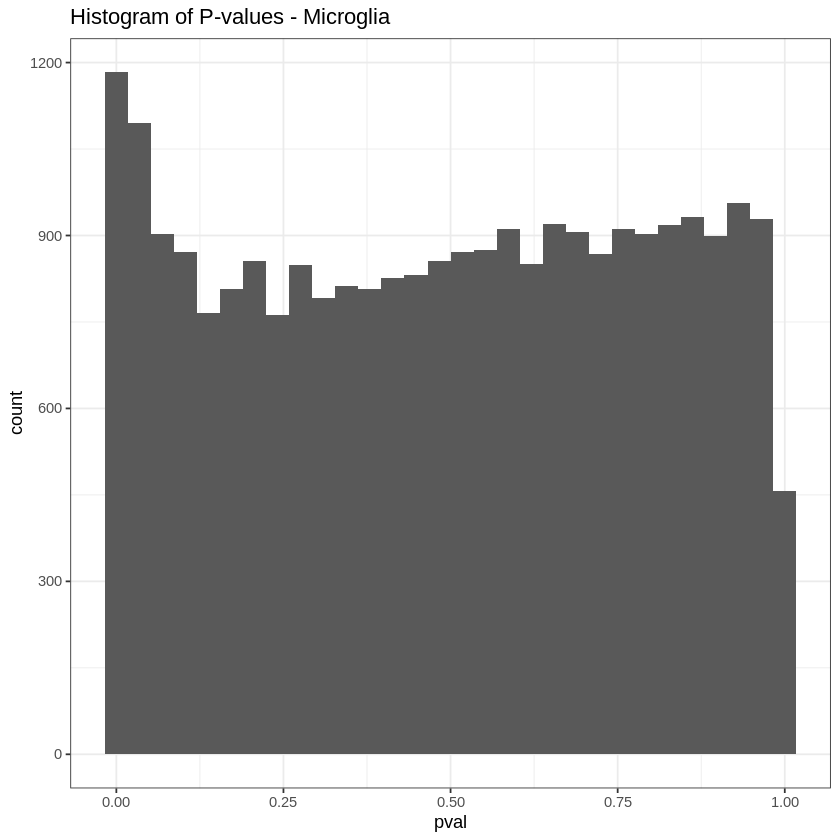

In [ ]:
# Arrange the values in ascending order
Results_phylolm_reorder_micro <- Results_phylolm_micro[order(Results_phylolm_micro$pval, decreasing=F), ] 

dim(Results_phylolm_reorder_micro)


#Use to plot the histogram of p-values
curP_micro <- ggplot(Results_phylolm_reorder_micro, aes(x = pval)) + #Set the data variables to use
  geom_histogram() + #This specifies that you would like a scatter plot
  #geom_smooth(method='lm', formula= y~x) + #This creates a trend line
  ggtitle("Histogram of P-values - Microglia") + #This creates a title for the plot
  theme_bw(); #This sets a basic theme for the plot style

print(curP_micro); #Print the plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 257 rows containing non-finite values (`stat_bin()`).”


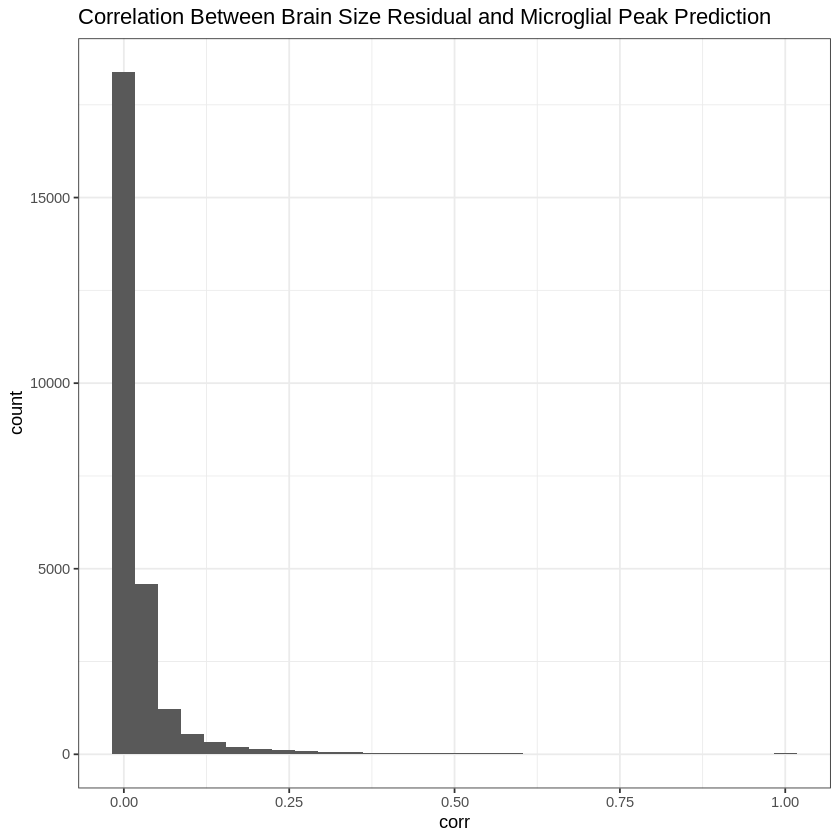

In [ ]:
#Use to plot the histogram of p-values
curP_micro <- ggplot(Results_phylolm_reorder_micro, aes(x = corr)) + #Set the data variables to use
  geom_histogram() + #This specifies that you would like a scatter plot
  #geom_smooth(method='lm', formula= y~x) + #This creates a trend line
  ggtitle("Correlation Between Brain Size Residual and Microglial Peak Prediction") + #This creates a title for the plot
  theme_bw(); #This sets a basic theme for the plot style

print(curP_micro); #Print the plot

In [ ]:
# Adjusting p-values using Bonferroni method
Results_phylolm_reorder_micro$padj = p.adjust(Results_phylolm_reorder_micro$pval)

# Finding the statistically significant peaks
significant_micro = na.omit(Results_phylolm_reorder_micro[Results_phylolm_reorder_micro$padj <= 0.1, ])
significant_micro;
dim(significant_micro)

,X,id,pval,corr,adj_corr,padj
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
22591,22591,22591,4.590132e-09,0.4278780,0.4186502,0.0001199034
10632,10632,10632,5.946320e-09,0.2638459,0.2572139,0.0001553238
15359,15359,15359,1.299916e-08,0.4413720,0.4313965,0.0003395380
16923,16923,16923,1.343928e-08,0.3755603,0.3665104,0.0003510205
24078,24078,24078,2.454625e-08,0.5356723,0.5243472,0.0006410991
1338,1338,1338,4.804754e-08,0.1910695,0.1853324,0.0012548575
17084,17084,17084,5.401770e-08,0.3424769,0.3332160,0.0014107263
16296,16296,16296,5.668419e-08,0.4999162,0.4882864,0.0014803077
6397,6397,6397,6.468963e-08,0.2005824,0.1944800,0.0016893050


[1] 54  6

In [ ]:
# Once again, rearrange the data frame to run the phylogenetic analysis correctly

OPC = opc_pred[, (colnames(opc_pred) %in% rownames(traits))]

OPC <- relocate(OPC, rownames(traits))





### Oligodendrocytes Precursor Cells

In [ ]:



# Performing the Phylogenetic Regression

Peaks <- rownames(OPC)

# Create vectors to store the results from the phylogenetic analysis
pval <- rep(NA,length(Peaks))
corr <- rep(NA,length(Peaks))
adj_corr <- rep(NA,length(Peaks))

Results_phylolm_opc = data.frame(id = Peaks, pval = pval, corr = corr, adj_corr = adj_corr)

rownames(Results_phylolm_opc) <- Results_phylolm_opc$Peaks

for(curPeak in Peaks){
  TempSpeciesInfo <- traits
  TempSpeciesInfo$currPeak <- as.numeric(t(OPC[curPeak,]))

  lmFit = suppressWarnings(phylolm(currPeak~Brain.resid, data = TempSpeciesInfo, phy = keepTree , model="BM"))
  lmFitSummary = suppressWarnings(summary(lmFit))

  Results_phylolm_opc[curPeak, "pval"] <- lmFitSummary$coefficients['Brain.resid',4]
  Results_phylolm_opc[curPeak, "corr"] <- lmFit$r.squared
  Results_phylolm_opc[curPeak, "adj_corr"] <- lmFit$adj.r.squared
}


ERROR: ignored

In [ ]:
#For the phylogenetic analysis of OPCs, around 250 of the peaks did not have enough data to assign meaningful results via Phylolm. 
#However, there are still over 30000 p-values that will be used in further analysis. 

In [ ]:
# Save the two data frames into a csv file (the model only needs to be run once) (also removes Infinities)

micro_out <- write.csv(Results_phylolm_micro, "micro.csv")
opc_out <- write.csv(Results_phylolm_opc, "opc.csv")



ERROR: ignored

In [ ]:
#Run the next two cells of code to remove all Inf and NAs that were produced from incomplete data by Phylolm

#Results_phylolm_micro <- read.csv("/content/micro.csv")
#Results_phylolm_opc <- read.csv("/content/opc.csv")

In [ ]:
Results_phylolm_micro <- na.omit(Results_phylolm_micro)
Results_phylolm_opc <- na.omit(Results_phylolm_opc)

#length(Results_phylolm_micro[,1])

# output should be 26122

#length(Results_phylolm_opc[,1])

# output should be 30286



[1] 26122

[1] 30286

[1] 40  6

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


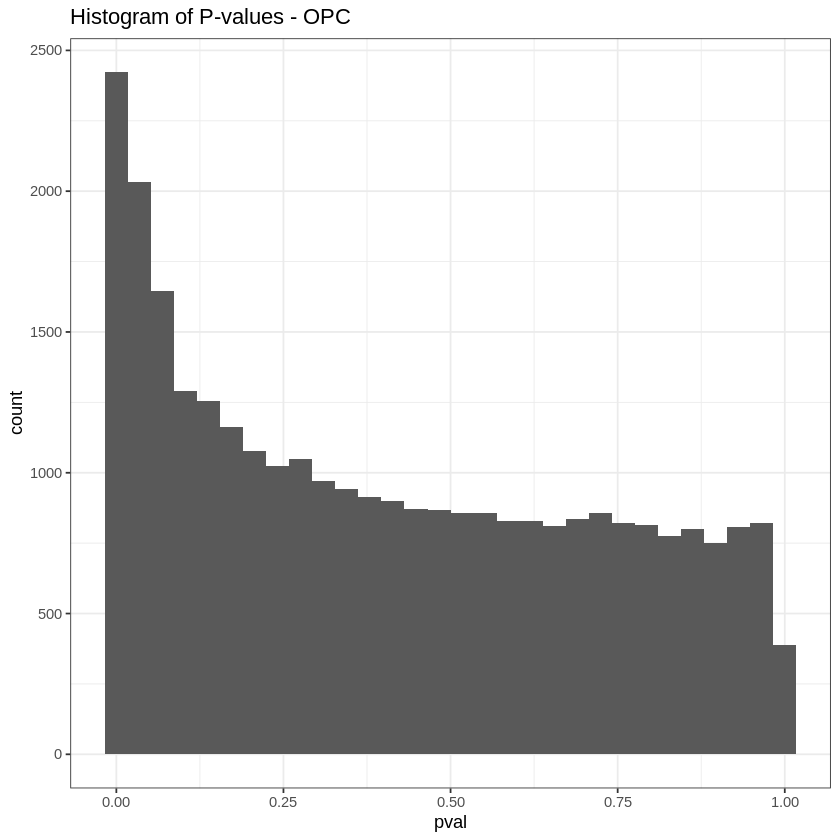

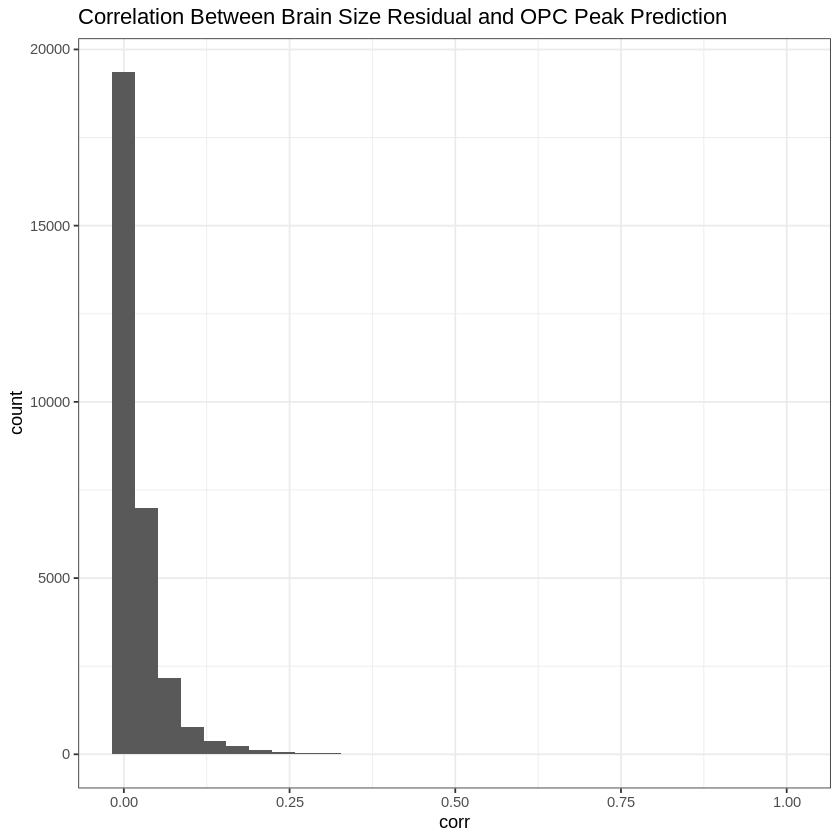

In [ ]:
# Adjust the p-values
Results_phylolm_reorder_opc = Results_phylolm_opc[order(Results_phylolm_opc$pval, decreasing=F), ] 
Results_phylolm_reorder_opc$padj = p.adjust(Results_phylolm_reorder_opc$pval)

# Find the significant peaks
significant_opc = na.omit(Results_phylolm_reorder_opc[Results_phylolm_reorder_opc$padj <= 0.1, ])
dim(significant_opc)

#Use to plot the histogram of p-values
curP <- ggplot(Results_phylolm_reorder_opc, aes(x = pval)) + #Set the data variables to use
  geom_histogram() + #This specifies that you would like a scatter plot
  #geom_smooth(method='lm', formula= y~x) + #This creates a trend line
  ggtitle("Histogram of P-values - OPC") + #This creates a title for the plot
  theme_bw(); #This sets a basic theme for the plot style

print(curP); #Print the plot

#Use to plot the histogram of Correlation
curP <- ggplot(Results_phylolm_reorder_opc, aes(x = corr)) + #Set the data variables to use
  geom_histogram() + #This specifies that you would like a scatter plot
  #geom_smooth(method='lm', formula= y~x) + #This creates a trend line
  ggtitle("Correlation Between Brain Size Residual and OPC Peak Prediction") + #This creates a title for the plot
  theme_bw(); #This sets a basic theme for the plot style

print(curP); #Print the plot



In [ ]:
#code that gives the chromosome location of the highest peaks. Change parameters to get different peaks and paste into UCSC.

sig_peak_opc <- significant_opc[1,1]
sig_peak_mic <- significant_micro[1,1]

sig_peak_m1 <- microglia_pred[sig_peak_mic, 1]
sig_peak_m1






[1] "hg38:chr10:129144087-129144587:250"

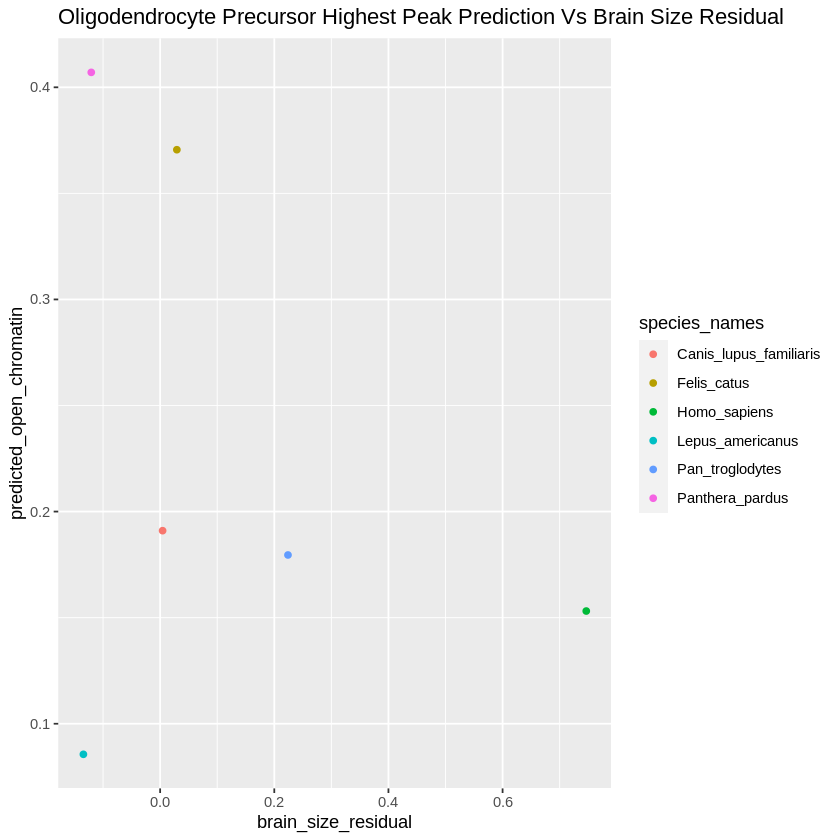

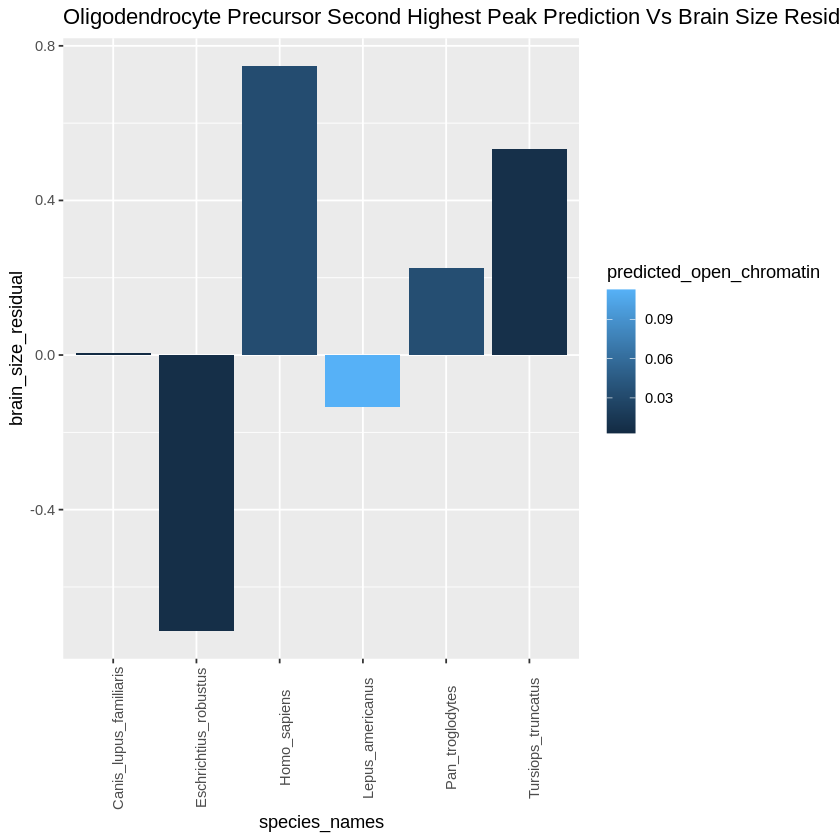

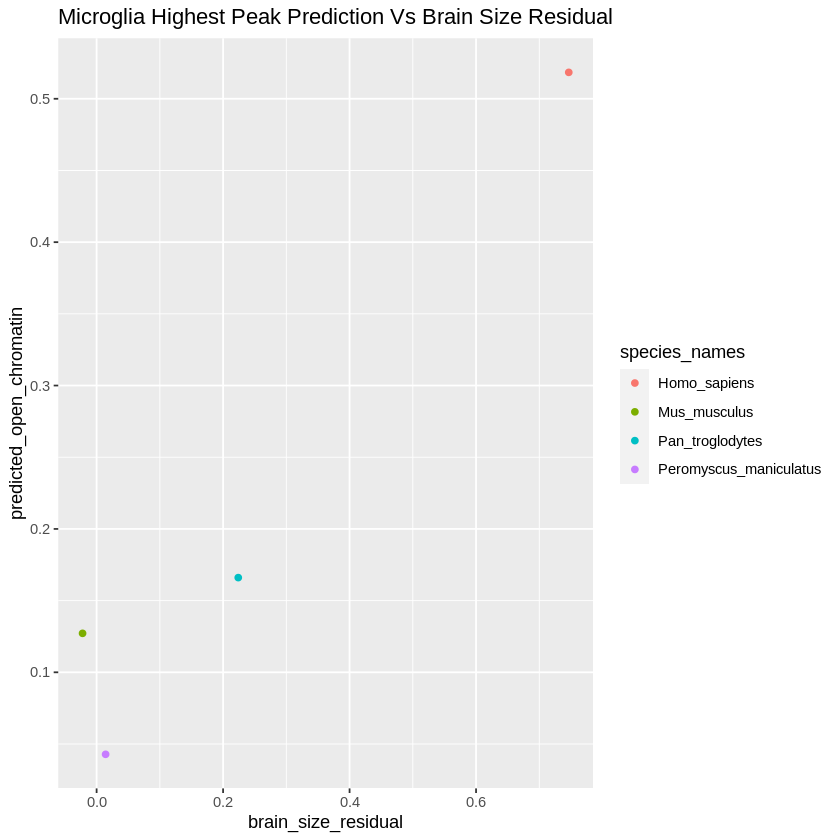

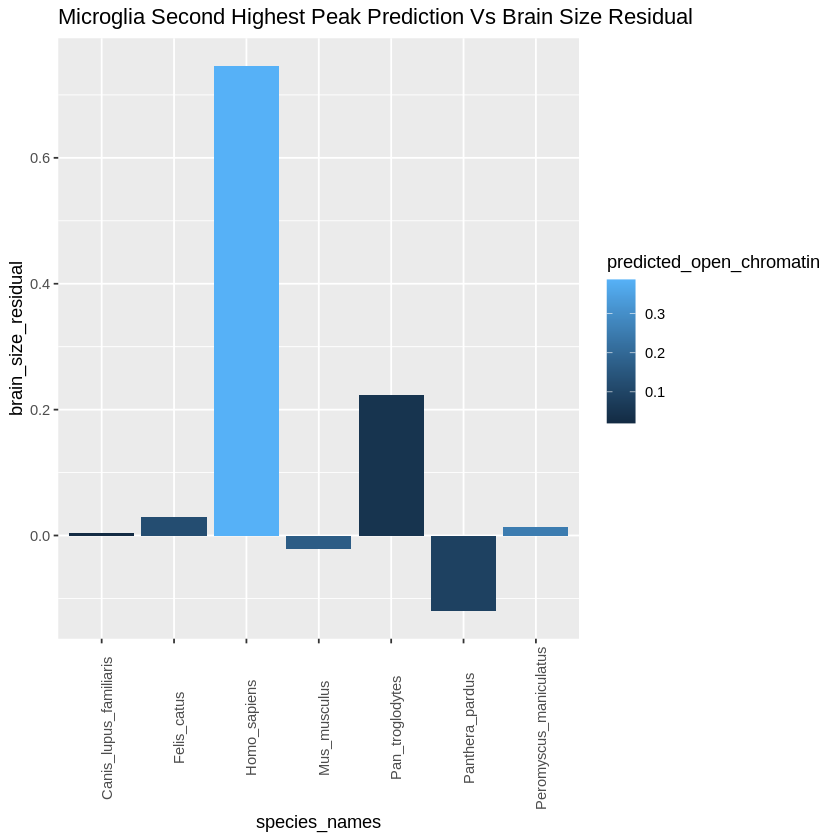

In [ ]:
species <- c('Eschrichtius_robustus', 'Lepus_americanus', 'Panthera_pardus', 'Mus_musculus', 'Canis_lupus_familiaris', 'Felis_catus', 'Pan_troglodytes', 'Tursiops_truncatus', 'Homo_sapiens', 'Peromyscus_maniculatus')


#####
predicted_open_chromatin <- c()
brain_size_residual <- c()
species_names <- c()
  
  peakID <- (significant_opc)[1,1]

 
  
  for (j in c(1:length(species))){
    
    if (!is.na(as.numeric(OPC[ peakID, species[j]]))){
    predicted_open_chromatin <- c(predicted_open_chromatin, as.numeric(OPC[ peakID, species[j]]))
    
    brain_size_residual <- c(brain_size_residual, traits[species[j],2])

    species_names <- c(species_names, species[j])
    }
      
  }

  OPCpeak1 <- data.frame(species_names, brain_size_residual, predicted_open_chromatin)

  ggplot(OPCpeak1, aes(color = species_names)) + geom_point(aes(x=brain_size_residual, y = predicted_open_chromatin)) +
    ggtitle("Oligodendrocyte Precursor Highest Peak Prediction Vs Brain Size Residual")

#####

#####

  predicted_open_chromatin <- c()
  brain_size_residual <- c()
  species_names <- c()

  peakID <- (significant_opc)[2,1]

   for (j in c(1:26408)){
    
    if (!is.na(as.numeric(OPC[ peakID, species[j]]))){
    predicted_open_chromatin <- c(predicted_open_chromatin, as.numeric(OPC[ peakID, species[j]]))
    
    brain_size_residual <- c(brain_size_residual, traits[species[j],2])

    species_names <- c(species_names, species[j])
    }
      
  }

  OPCpeak2 <- data.frame(species_names, brain_size_residual, predicted_open_chromatin)

  ggplot(OPCpeak2, aes(x = species_names, y = brain_size_residual, fill = predicted_open_chromatin), na.rm = TRUE) + geom_col() + 
    ggtitle("Oligodendrocyte Precursor Second Highest Peak Prediction Vs Brain Size Residual") + theme(axis.text.x = element_text(angle = 90))

#####

#####


predicted_open_chromatin <- c()
  brain_size_residual <- c()
  species_names <- c()

  peakID <- (significant_micro)[1,1]

   for (j in c(1:length(species))){
    
    if (!is.na(as.numeric(microglia_pred[ peakID, species[j]]))){
    predicted_open_chromatin <- c(predicted_open_chromatin, as.numeric(microglia_pred[ peakID, species[j]]))
    
    brain_size_residual <- c(brain_size_residual, traits[species[j],2])

    species_names <- c(species_names, species[j])
    }
      
  }

  MICpeak1 <- data.frame(species_names, brain_size_residual, predicted_open_chromatin)
  ggplot(MICpeak1, aes(color = species_names)) + geom_point(aes(x=brain_size_residual, y = predicted_open_chromatin)) +
    ggtitle("Microglia Highest Peak Prediction Vs Brain Size Residual") 

#####

#####

  predicted_open_chromatin <- c()
  brain_size_residual <- c()
  species_names <- c()

  peakID <- (significant_micro)[2,1]

   for (j in c(1:length(species))){
    
    if (!is.na(as.numeric(microglia_pred[ peakID, species[j]]))){
    predicted_open_chromatin <- c(predicted_open_chromatin, as.numeric(microglia_pred[ peakID, species[j]]))
    
    brain_size_residual <- c(brain_size_residual, traits[species[j],2])

    species_names <- c(species_names, species[j])
    }
      
  }

  MICpeak2 <- data.frame(species_names, brain_size_residual, predicted_open_chromatin)

  ggplot(MICpeak2, aes(x = species_names, y = brain_size_residual, fill = predicted_open_chromatin), na.rm = TRUE) + geom_col() + 
    ggtitle("Microglia Second Highest Peak Prediction Vs Brain Size Residual") + theme(axis.text.x = element_text(angle = 90))




In [ ]:
install.packages("stringr")
require(stringr)
options(scipen = 999)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: stringr



In [ ]:
# Microglia correlated
Results_phylolm_reorder_micro = na.omit(Results_phylolm_reorder_micro)
neg_corr = Results_phylolm_reorder_micro[(Results_phylolm_reorder_micro$adj_corr < 0),]
pos_corr = Results_phylolm_reorder_micro[(Results_phylolm_reorder_micro$adj_corr > 0),]

pos_micro = head(pos_corr[order(pos_corr$pval, decreasing=F), ] , n = 200) 
bed_pos_micro <- as.data.frame(microglia_pred[rownames(pos_micro), ]$name)
colnames(bed_pos_micro) = 'name'
bed_pos_micro[c("genome","position")] <- str_split_fixed(bed_pos_micro$name, ':', 2)
bed_pos_micro[c("chr", "pos")] <- str_split_fixed(bed_pos_micro$position, ':', 2)
bed_pos_micro[c("start", "stop")] <- str_split_fixed(bed_pos_micro$pos, '-', 2)
bed_pos_micro[c("stop", "last")] <- str_split_fixed(bed_pos_micro$stop, ':', 2)
bed_pos_micro = bed_pos_micro[, c("chr", "start", "stop")]
bed_pos_micro$start = as.numeric(bed_pos_micro$start)
bed_pos_micro$stop = as.numeric(bed_pos_micro$stop)
bed_pos_micro$stop = as.numeric(bed_pos_micro$stop)
head(bed_pos_micro)
write.table(bed_pos_micro, "micro_pos_bed.bed", row.names = FALSE, col.names = FALSE, sep="\t", quote=FALSE)

neg_micro = head(neg_corr[order(neg_corr$pval, decreasing=F), ] , n = 200)
bed_neg_micro <- as.data.frame(microglia_pred[rownames(neg_micro), ]$name)
colnames(bed_neg_micro) = 'name'
bed_neg_micro[c("genome","position")] <- str_split_fixed(bed_neg_micro$name, ':', 2)
bed_neg_micro[c("chr", "pos")] <- str_split_fixed(bed_neg_micro$position, ':', 2)
bed_neg_micro[c("start", "stop")] <- str_split_fixed(bed_neg_micro$pos, '-', 2)
bed_neg_micro[c("stop", "last")] <- str_split_fixed(bed_neg_micro$stop, ':', 2)
bed_neg_micro = bed_neg_micro[, c("chr", "start", "stop")]
bed_neg_micro$start = as.numeric(bed_neg_micro$start)
bed_neg_micro$stop = as.numeric(bed_neg_micro$stop)
bed_neg_micro$stop = as.numeric(bed_neg_micro$stop)
head(bed_neg_micro)
write.table(bed_neg_micro, "micro_neg_bed.bed", row.names = FALSE, col.names = FALSE, sep="\t", quote=FALSE)


,chr,start,stop
,<chr>,<dbl>,<dbl>
1,chr3,100045649,100046149
2,chr3,23072226,23072726
3,chrX,130832333,130832833
4,chr18,59078713,59079213
5,chr20,19705716,19706216
6,chr10,32319126,32319626


,chr,start,stop
,<chr>,<dbl>,<dbl>
1,chr2,140929795,140930295
2,chr20,22371826,22372326
3,chr2,207311345,207311845
4,chr10,88064665,88065165
5,chr4,40551109,40551609
6,chr4,83639828,83640328


In [ ]:
# Microglia all Peaks
Results_phylolm_reorder_micro = na.omit(Results_phylolm_reorder_micro)

bed_micro <- as.data.frame(microglia_pred$name)
colnames(bed_micro) = 'name'
bed_micro[c("genome","position")] <- str_split_fixed(bed_micro$name, ':', 2)
bed_micro[c("chr", "pos")] <- str_split_fixed(bed_micro$position, ':', 2)
bed_micro[c("start", "stop")] <- str_split_fixed(bed_micro$pos, '-', 2)
bed_micro[c("stop", "last")] <- str_split_fixed(bed_micro$stop, ':', 2)
bed_micro = bed_micro[, c("chr", "start", "stop")]
bed_micro$start = as.numeric(bed_micro$start)
bed_micro$stop = as.numeric(bed_micro$stop)
bed_micro$stop = as.numeric(bed_micro$stop)
head(bed_micro)
write.table(bed_micro, "micro_bed.bed", row.names = FALSE, col.names = FALSE, sep="\t", quote=FALSE)



,chr,start,stop
,<chr>,<dbl>,<dbl>
1,chr2,141497234,141497734
2,chr10,103645101,103645601
3,chr10,103650680,103651180
4,chr10,103659858,103660358
5,chr10,103660367,103660867
6,chr2,141313988,141314488


In [ ]:
# OPC correlated
neg_corr = Results_phylolm_reorder_micro[(Results_phylolm_reorder_opc$adj_corr < 0),]
pos_corr = Results_phylolm_reorder_micro[(Results_phylolm_reorder_opc$adj_corr > 0),]

pos_opc = head(pos_corr[order(pos_corr$pval, decreasing=F), ], n = 200) 
bed_pos_poc <- as.data.frame(opc_pred[rownames(pos_opc), ]$name)
colnames(bed_pos_poc) = 'name'
bed_pos_poc[c("genome","position")] <- str_split_fixed(bed_pos_poc$name, ':', 2)
bed_pos_poc[c("chr", "pos")] <- str_split_fixed(bed_pos_poc$position, ':', 2)
bed_pos_poc[c("start", "stop")] <- str_split_fixed(bed_pos_poc$pos, '-', 2)
bed_pos_poc[c("stop", "last")] <- str_split_fixed(bed_pos_poc$stop, ':', 2)
bed_pos_poc = bed_pos_poc[, c("chr", "start", "stop")]
bed_pos_poc$start = as.numeric(bed_pos_poc$start)
bed_pos_poc$stop = as.numeric(bed_pos_poc$stop)
bed_pos_poc$stop = as.numeric(bed_pos_poc$stop)
head(bed_pos_poc)
write.table(bed_pos_poc, "opc_pos_bed.bed", row.names = FALSE, col.names = FALSE, sep="\t", quote=FALSE)

neg_opc = head(neg_corr[order(neg_corr$pval, decreasing=F), ] , n = 200)
bed_neg_opc <- as.data.frame(opc_pred[rownames(neg_opc), ]$name)
colnames(bed_neg_opc) = 'name'
bed_neg_opc[c("genome","position")] <- str_split_fixed(bed_neg_opc$name, ':', 2)
bed_neg_opc[c("chr", "pos")] <- str_split_fixed(bed_neg_opc$position, ':', 2)
bed_neg_opc[c("start", "stop")] <- str_split_fixed(bed_neg_opc$pos, '-', 2)
bed_neg_opc[c("stop", "last")] <- str_split_fixed(bed_neg_opc$stop, ':', 2)
bed_neg_opc = bed_neg_opc[, c("chr", "start", "stop")]
bed_neg_opc$start = as.numeric(bed_neg_opc$start)
bed_neg_opc$stop = as.numeric(bed_neg_opc$stop)
bed_neg_opc$stop = as.numeric(bed_neg_opc$stop)
head(bed_neg_opc)
write.table(bed_neg_opc, "opc_neg_bed.bed", row.names = FALSE, col.names = FALSE, sep="\t", quote=FALSE)

,chr,start,stop
,<chr>,<dbl>,<dbl>
1,chr1,175567043,175567543
2,chr4,138870940,138871440
3,chr2,57881241,57881741
4,chr6,1574744,1575244
5,chr10,125093756,125094256
6,chr19,7197131,7197631


,chr,start,stop
,<chr>,<dbl>,<dbl>
1,chr13,114064944,114065444
2,chr4,156944563,156945063
3,chr9,77968384,77968884
4,chr1,175681509,175682009
5,chr1,175493892,175494392
6,chr3,165814316,165814816


In [ ]:
# OPC all Peaks
Results_phylolm_reorder_micro = na.omit(Results_phylolm_reorder_micro)

bed_opc <- as.data.frame(opc_pred$name)
colnames(bed_opc) = 'name'
bed_opc[c("genome","position")] <- str_split_fixed(bed_opc$name, ':', 2)
bed_opc[c("chr", "pos")] <- str_split_fixed(bed_opc$position, ':', 2)
bed_opc[c("start", "stop")] <- str_split_fixed(bed_opc$pos, '-', 2)
bed_opc[c("stop", "last")] <- str_split_fixed(bed_opc$stop, ':', 2)
bed_opc = bed_opc[, c("chr", "start", "stop")]
bed_opc$start = as.numeric(bed_opc$start)
bed_opc$stop = as.numeric(bed_opc$stop)
bed_opc$stop = as.numeric(bed_opc$stop)
head(bed_opc)
write.table(bed_opc, "opc_bed.bed", row.names = FALSE, col.names = FALSE, sep="\t", quote=FALSE)

,chr,start,stop
,<chr>,<dbl>,<dbl>
1,chr15,89434828,89435328
2,chr15,89436431,89436931
3,chr15,89438289,89438789
4,chr15,89438956,89439456
5,chr15,89442645,89443145
6,chr15,89443547,89444047


In [ ]:
str(significant_micro)
str(significant_opc)

'data.frame':	25 obs. of  5 variables:
 $ id      : chr  "1707" "9329" "9877" "21182" ...
 $ pval    : num  0.00000000189 0.00000000498 0.00000001846 0.00000007651 0.00000013671 ...
 $ corr    : num  0.221 0.284 0.204 0.442 0.187 ...
 $ adj_corr: num  0.216 0.277 0.199 0.431 0.181 ...
 $ padj    : num  0.0000494 0.0001301 0.0004821 0.0019983 0.0035706 ...
 - attr(*, "na.action")= 'omit' Named int [1:286] 26 27 28 29 30 31 32 33 34 35 ...
  ..- attr(*, "names")= chr [1:286] "NA" "NA.1" "NA.2" "NA.3" ...
'data.frame':	40 obs. of  5 variables:
 $ id      : chr  "247" "24243" "1588" "15646" ...
 $ pval    : num  0.000000000104 0.000000000506 0.00000000279 0.000000004457 0.000000004911 ...
 $ corr    : num  0.299 0.317 0.25 0.303 0.277 ...
 $ adj_corr: num  0.293 0.31 0.244 0.295 0.27 ...
 $ padj    : num  0.00000314 0.00001533 0.00008448 0.00013496 0.00014873 ...
 - attr(*, "na.action")= 'omit' Named int [1:262] 41 42 43 44 45 46 47 48 49 50 ...
  ..- attr(*, "names")= chr [1:262] "NA" "NA